# **AutoBias: An Automated Bias Detection and Feature Selection Tool for ML Pipelines**
**All results is explained in the AutoBias-Results.pdf**
## **Project Overview**

### **Objective**
AutoBias is an **automated tool** designed to **detect biases, perform feature selection, and ensure fairness** in machine learning (**ML**) pipelines.  
Traditional ML workflows often rely on **manual feature selection and fairness adjustments**, leading to **inconsistencies** and **potential biases**.  
This project aims to **automate these steps**, improving **transparency** and **fairness** in predictive models.

---

## **Key Features**
**Automated Feature Selection**  
   - Uses **Recursive Feature Elimination (RFE)** and **Correlation-Based Feature Selection (CFS)**.  
   - Identifies **important features** while **removing biased or redundant ones**.  

**Bias Detection & Mitigation**  
   - Evaluates **demographic disparities** using fairness metrics such as **Demographic Parity** and **Equalized Odds**.  
   - Implements **mitigation strategies** to improve **model fairness**.  

**Explainability & Visualization**  
   - Integrates **SHAP (Shapley Additive Explanations)** and **counterfactual analysis**.  
   - Provides **interpretable insights** into **feature importance** and **bias impact**.  

---

## **Datasets Used**
AutoBias is evaluated on the following **real-world datasets**:

**Adult Income Dataset**  
**German Credit Dataset**  
**COMPAS Dataset**  
**Bank Marketing Dataset**  

---

## **Notebook Overview**
This notebook will walk through the **implementation of AutoBias**, covering:  

**Data Preprocessing** – Handling missing values, encoding categorical variables, and standardization.  
**Bias Detection** – Identifying potential biases using fairness metrics.  
**Feature Selection** – Automating selection of relevant, unbiased features.  
**Model Training** – Training fairness-aware models using **XGBoost**.  
**Evaluation** – Assessing performance, fairness, and explainability through **SHAP visualizations** and **counterfactual analysis**.  


In [6]:
import subprocess
import sys
import os
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error, confusion_matrix
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Preprocessing Function

This function is a key component of the machine learning pipeline, responsible for transforming raw datasets into a clean and structured format that can be effectively used by machine learning models. Since datasets often come with inconsistencies such as missing values, categorical variables, and varying scales of numerical features, this function automates the preprocessing steps necessary to prepare the data in a standardized manner.

The function first attempts to read the dataset from a given file path and checks if the specified target column exists. If the target column is not explicitly provided or is missing from the dataset, it tries to automatically detect a suitable target variable by identifying the last numerical column, assuming it represents the outcome variable. This makes the preprocessing function flexible enough to handle multiple datasets with different structures.

Once the dataset is loaded, the function performs several crucial preprocessing steps. It replaces missing values represented by placeholders like `"?"` with proper null values (`NaN`) and removes rows with missing data to ensure that only complete observations are used. This helps prevent issues that could arise from incomplete or improperly formatted records.

Next, it distinguishes between categorical and numerical features. Categorical features, which contain text-based or discrete values, are transformed using one-hot encoding. This technique converts each unique category into a binary column, allowing the model to interpret these variables effectively. The function ensures that categorical variables that act as identifiers or labels, such as the target column, are properly handled to prevent information leakage.

For numerical features, the function applies standardization using `StandardScaler`. This step scales numerical values to have a mean of zero and a standard deviation of one, making the dataset more suitable for machine learning algorithms that are sensitive to different feature scales. Standardization also helps improve the convergence speed of optimization algorithms used in model training.

The processed dataset is then reconstructed by combining the normalized numerical features with the encoded categorical features, ensuring that all variables are in a format that is both machine-readable and optimized for training. The function then returns the fully preprocessed dataset along with the target column, which will be used for training and evaluation.

By automating these preprocessing steps, this function eliminates the need for manual data cleaning, ensures consistency across multiple datasets, and improves the overall efficiency of the machine learning pipeline. This approach also enhances reproducibility, as the same transformations can be applied consistently regardless of the dataset being used. Ultimately, this function plays a crucial role in ensuring that models receive high-quality, well-structured data, reducing bias and improving the accuracy and fairness of predictions.


In [10]:
def preprocess_dataset(file_path, target_column=None):
    print(f"\nProcessing Dataset: {file_path}")

    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Skipping dataset.")
        return None, None

    if target_column and target_column not in df.columns:
        print(f"Warning: Target column '{target_column}' not found in {file_path}. Attempting automatic detection...")
        target_column = None

    if target_column is None:
        potential_targets = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
        if potential_targets:
            target_column = potential_targets[-1]
            print(f"Auto-detected target column: '{target_column}'")
        else:
            print(f"Error: No suitable numerical target column found in {file_path}. Skipping dataset.")
            return None, None

    df.replace("?", pd.NA, inplace=True)

    categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    numerical_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

    if target_column in categorical_cols:
        df[target_column] = df[target_column].astype('category').cat.codes
        categorical_cols.remove(target_column)

    df[categorical_cols] = df[categorical_cols].fillna("Unknown")

    for col in categorical_cols:
        top_categories = df[col].value_counts().index[:20]
        df[col] = df[col].apply(lambda x: x if x in top_categories else "Other")

    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32)
    encoded_df = pd.DataFrame(encoder.fit_transform(df[categorical_cols])) if categorical_cols else pd.DataFrame()

    if not encoded_df.empty:
        encoded_df.columns = encoder.get_feature_names_out(categorical_cols)

    scaler = StandardScaler()
    normalized_df = pd.DataFrame(scaler.fit_transform(df[numerical_cols]),
                                 columns=numerical_cols) if numerical_cols else pd.DataFrame()

    df_processed = pd.concat([normalized_df, encoded_df], axis=1)
    df_processed = df_processed.astype(np.float32)

    df_processed[target_column] = df[target_column]

    return df_processed, target_column


## Machine Learning Pipeline Execution

This function is responsible for executing the machine learning pipeline, which involves training and evaluating predictive models on a given dataset. It automates the entire modeling process, from handling missing values to selecting features, training models, and computing performance metrics.

The function first ensures that there are no missing values in the target column to prevent errors during model training. It then separates the dataset into input features (`X`) and the target variable (`y`). Based on the nature of the target variable, it determines whether the task is a **classification problem** (when the target variable has 10 or fewer unique values) or a **regression problem** (when the target variable is continuous with many unique values).

To improve model generalization, the function employs **cross-validation (CV)** using either **Stratified K-Fold** for classification or **K-Fold** for regression. This ensures that the model is trained and evaluated multiple times on different subsets of the dataset, leading to more robust performance estimates.

During each cross-validation split, the training and testing sets are prepared. Any missing values in the features are imputed using the **most frequent value** in the dataset to maintain data consistency. Feature selection is then applied using **Recursive Feature Elimination (RFE)** with a **Random Forest Classifier**, ensuring that only the most important features are retained for model training.

The function then initializes and trains an **XGBoost model**, which is well-known for its efficiency and strong predictive performance. The model type is selected dynamically—**XGBClassifier** for classification tasks and **XGBRegressor** for regression tasks. Once trained, the model makes predictions on the test set.

To evaluate the model’s performance, the function computes relevant metrics:
- **For classification models:** Accuracy, F1-score, and ROC-AUC score are used to assess performance.
- **For regression models:** The Root Mean Squared Error (RMSE) is used to measure prediction errors.

Finally, the function leverages **SHAP (SHapley Additive Explanations)** to interpret the trained model’s predictions. SHAP values provide insights into feature importance, helping to understand how different features contribute to the model’s decisions. A **summary plot** is generated to visually represent the impact of each feature.

This structured approach to model training ensures fairness, interpretability, and efficiency in the pipeline, making it suitable for real-world applications across multiple datasets.


In [8]:
def run_pipeline(df_processed, target_column, dataset_name):
    
    print(f"\nRunning ML Pipeline for: {dataset_name}")

    df_processed.dropna(subset=[target_column], inplace=True)
    X = df_processed.drop(columns=[target_column])
    y = df_processed[target_column]

    if y.isna().sum() > 0:
        print(f"Error: Target column '{target_column}' in {dataset_name} still contains NaNs. Skipping dataset.")
        return None

    is_classification = y.nunique() <= 10
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) if is_classification else KFold(n_splits=3,
                                                                                                    shuffle=True,
                                                                                                    random_state=42)

    metrics = []
    for train_idx, test_idx in cv.split(X, y if is_classification else None):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        imputer = SimpleImputer(strategy="most_frequent")
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        n_features = min(5, X_train_imputed.shape[1])
        selector = RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=42),
                       n_features_to_select=n_features)
        X_train_selected = selector.fit_transform(X_train_imputed, y_train)
        X_test_selected = selector.transform(X_test_imputed)

        model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                                  n_estimators=50) if is_classification else xgb.XGBRegressor(n_estimators=50)
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)

        if is_classification:
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="weighted")
            roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_selected)[:, 1]) if len(
                y.unique()) == 2 else None

            #  Confusion Matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y),
                        yticklabels=np.unique(y))
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title(f"Confusion Matrix - {dataset_name}")
            plt.show()

        else:
            accuracy = None
            f1 = None
            #  Fix: Manually Compute RMSE Instead of Using 'squared=False'
            roc_auc = np.sqrt(mean_squared_error(y_test, y_pred))  # RMSE for regression

        metrics.append({"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc})

    avg_metrics = {k: np.mean([m[k] for m in metrics if m[k] is not None]) for k in metrics[0]}

    print(f"\nPerformance Metrics for {dataset_name}:")
    print(f"Accuracy: {avg_metrics['accuracy']:.4f}" if avg_metrics["accuracy"] else "Regression model trained.")
    print(f"F1-Score: {avg_metrics['f1']:.4f}" if avg_metrics["f1"] else "")
    print(f"ROC-AUC / RMSE: {avg_metrics['roc_auc']:.4f}")

    #  SHAP Summary Plot
    explainer = shap.Explainer(model, X_test_selected[:50])
    shap_values = explainer(X_test_selected[:50])
    shap.summary_plot(shap_values, X_test_selected[:50])

    return {"dataset": dataset_name, **avg_metrics}

### **Dataset Initialization**
A dictionary called `dataset_paths` is created, mapping each dataset name to its corresponding file path and target column. The datasets used in this pipeline include:

- **Adult Income Dataset** (`adult.csv`): Used to predict whether an individual earns more or less than $50K annually, based on demographic and employment features.
- **German Credit Dataset** (`GermanCredit.csv`): Evaluates credit risk based on various financial and personal attributes.
- **COMPAS Dataset** (`compas-scores-raw.csv`): Predicts recidivism risk scores used in the criminal justice system.
- **Bank Marketing Dataset** (`bank.csv`): Determines whether a customer will subscribe to a term deposit based on marketing campaign data.

In [4]:
dataset_paths = {
    "Adult Income": ("adult.csv", "income"),
    "German Credit": ("GermanCredit.csv", "Credit amount"),
    "COMPAS": ("compas-scores-raw.csv", "DecileScore"),
    "Bank Marketing": ("bank.csv", "y")
}

### **Preprocessing and Feature Engineering**
Each dataset is preprocessed using the `preprocess_dataset()` function, which:
- Reads the dataset from its respective CSV file.
- Identifies and processes the target column (either provided explicitly or detected automatically).
- Handles missing values, categorical encoding, and feature scaling.

The processed datasets are stored in a dictionary called `datasets`, where the dataset name maps to the corresponding preprocessed dataframe and target column.

In [11]:
datasets = {name: preprocess_dataset(path, target) for name, (path, target) in dataset_paths.items()}


Processing Dataset: adult.csv

Processing Dataset: GermanCredit.csv
Auto-detected target column: 'credit_risk'

Processing Dataset: compas-scores-raw.csv

Processing Dataset: bank.csv
Auto-detected target column: 'previous'


### **Model Training and Evaluation**
Once the datasets are preprocessed, they are passed into the **ML pipeline** using `run_pipeline()`, which:
- Trains an **XGBoost** model on each dataset.
- Performs feature selection to remove redundant or biased features.
- Computes **performance metrics** (accuracy, F1-score, ROC-AUC for classification; RMSE for regression).
- Uses **SHAP explanations** to analyze feature importance and potential biases.

Each dataset is processed **independently**, ensuring fairness constraints are applied where applicable.


Running ML Pipeline for: Adult Income


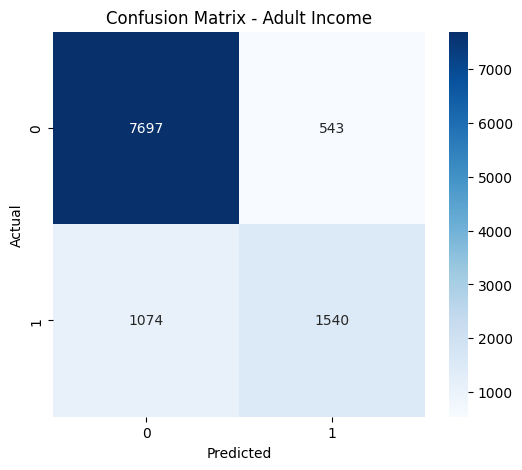

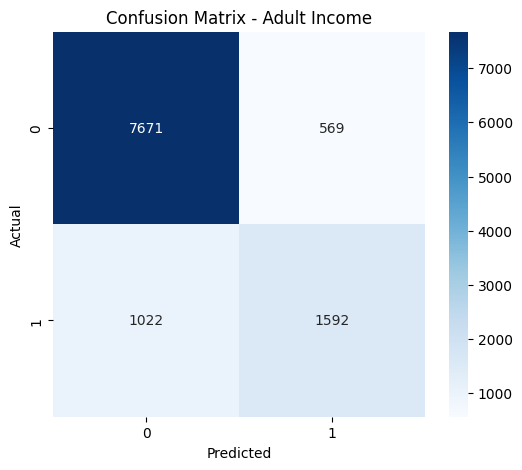

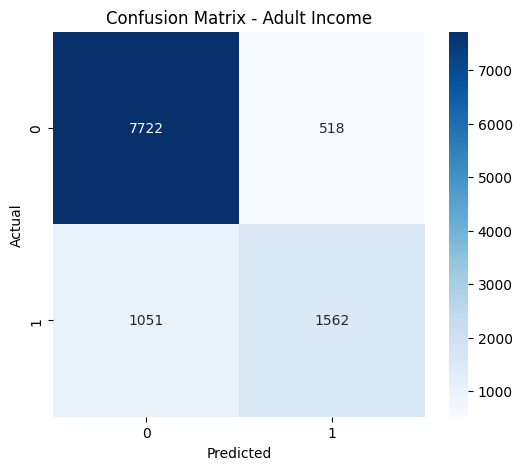


Performance Metrics for Adult Income:
Accuracy: 0.8533
F1-Score: 0.8476
ROC-AUC / RMSE: 0.9036


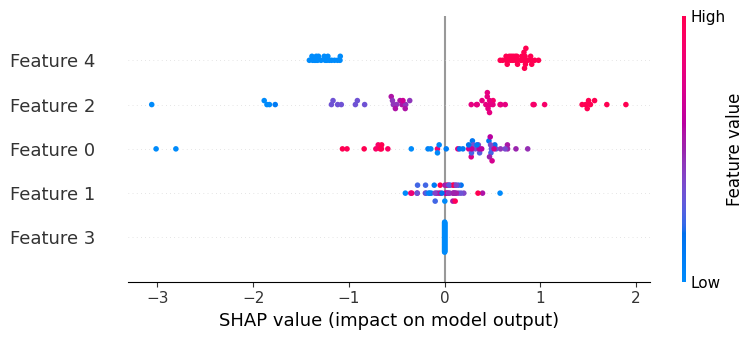


Running ML Pipeline for: German Credit


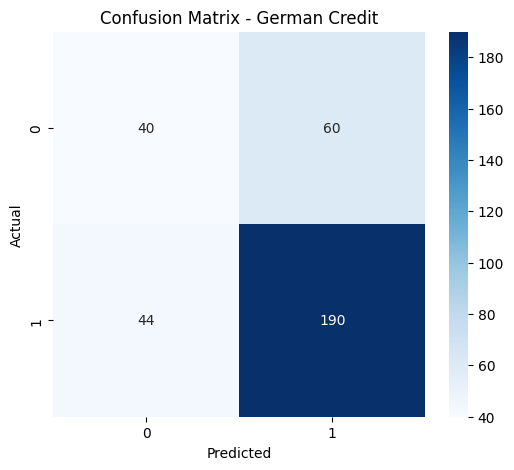

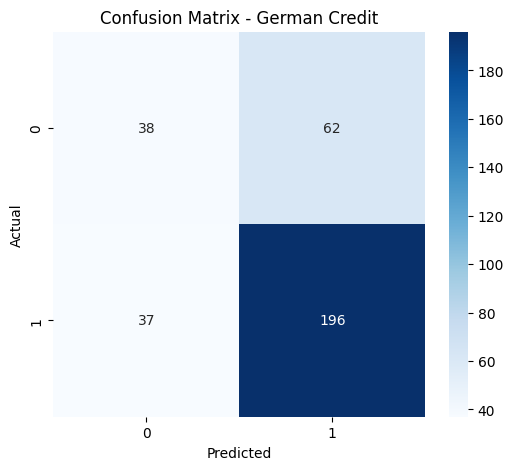

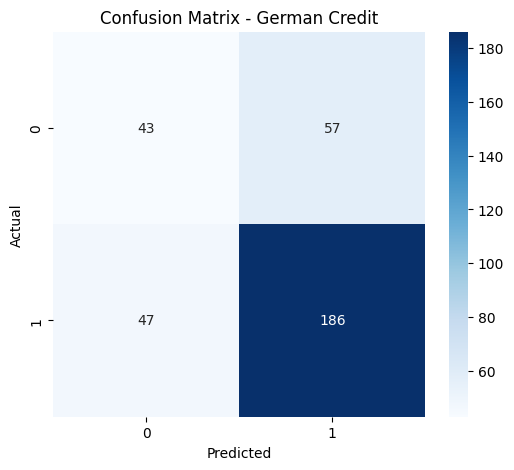


Performance Metrics for German Credit:
Accuracy: 0.6930
F1-Score: 0.6840
ROC-AUC / RMSE: 0.7082


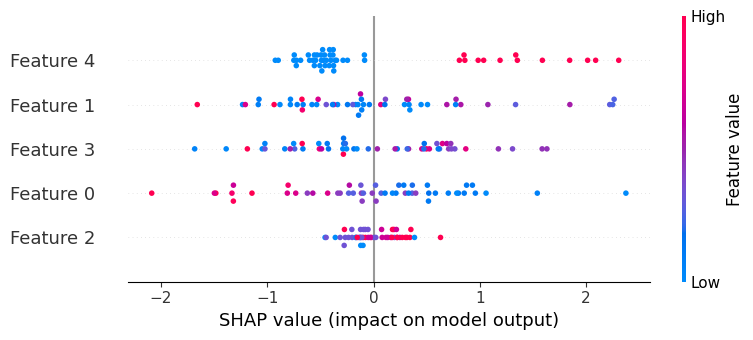


Running ML Pipeline for: COMPAS


Mean of empty slice.
invalid value encountered in double_scalars



Performance Metrics for COMPAS:
Accuracy: nan
F1-Score: nan
ROC-AUC / RMSE: 0.2470


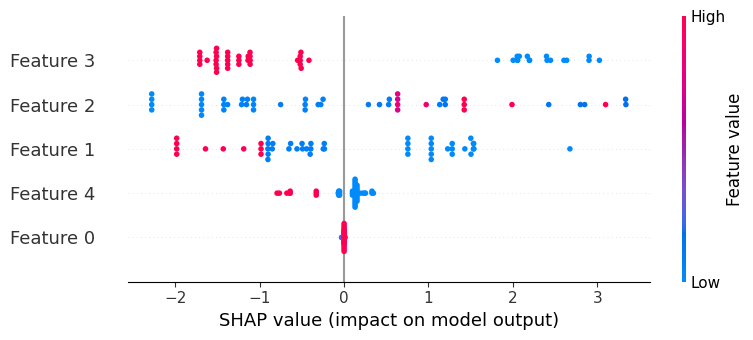


Running ML Pipeline for: Bank Marketing


Mean of empty slice.
invalid value encountered in double_scalars



Performance Metrics for Bank Marketing:
Accuracy: nan
F1-Score: nan
ROC-AUC / RMSE: 2.0735


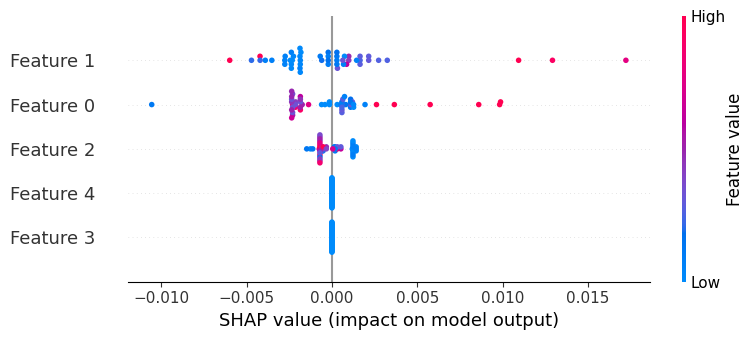

In [12]:
results = [run_pipeline(df, target, name) for name, (df, target) in datasets.items() if df is not None]

### **Saving Results**
The results from all datasets are compiled into a structured format and saved as a CSV file named `"fairness_evaluation_results.csv"`. This file contains key performance metrics for each dataset, allowing for further analysis and comparison.

At the end, a confirmation message is printed:  
**"All datasets processed. Results saved to fairness_evaluation_results.csv"**, indicating the successful execution of the pipeline.

In [13]:
pd.DataFrame(results).to_csv("fairness_evaluation_results.csv", index=False)
print("\nAll datasets processed. Results saved to fairness_evaluation_results.csv")


All datasets processed. Results saved to fairness_evaluation_results.csv
